In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_name = "merged_vaers_covid19.csv"
df = pd.read_csv(file_name)

df = df.dropna()
df.head()

,VAERS_ID,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,ORDER_x,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,ORDER_y
1,1159817.0,MODERNA,017B21A,1,IM,LA,2.0,Erythema,28.0,Joint swelling,28.0,Lymphadenopathy,28.0,Pruritus,28.0,Skin warm,28.0,2
5,1537124.0,PFIZER\BIONTECH,EW981,1,IM,LA,4.0,Antibody test normal,27.1,Anxiety,27.1,Biopsy skin,27.1,Blood magnesium normal,27.1,Blood phosphorus normal,27.1,4
6,1537124.0,PFIZER\BIONTECH,EW981,1,IM,LA,4.0,Blood thyroid stimulating hormone normal,27.1,C-reactive protein normal,27.1,Computerised tomogram head normal,27.1,Depression,27.1,Differential white blood cell count normal,27.1,4
7,1537124.0,PFIZER\BIONTECH,EW981,1,IM,LA,4.0,Electric shock sensation,27.1,Electromyogram normal,27.1,Fear,27.1,Full blood count normal,27.1,Impaired work ability,27.1,4
8,1537124.0,PFIZER\BIONTECH,EW981,1,IM,LA,4.0,Insomnia,27.1,Laboratory test normal,27.1,Lipase normal,27.1,Magnetic resonance imaging spinal normal,27.1,Metabolic function test normal,27.1,4


In [35]:
#Feature Engineering: Target Variable (IS_SEVERE)
symptom_cols = [f'SYMPTOM{i}' for i in range(1, 6)]

def check_severity(row):
    search_terms = ['DEATH', 'SEIZURE', 'VENTRICULAR EXTRASYSTOLES', 'VENTRICULAR TACHYCARDIA', 'CHRONIC INFLAMMATORY DEMYELINATING POLYRADICULONEUROPATHY', 'VENTRICULAR FIBRILLATION', 'NEAR DEATH EXPERIENCE', 'ISCHAEMIC STROKE', 'SEIZURE LIKE PHENOMENA']

    # Convert row to string, make uppercase, and check for any term
    symptoms = row.astype(str).str.upper().tolist()
    for symptom in symptoms:
        for term in search_terms:
            if term in symptom:
                return 1
    return 0

df['IS_SEVERE'] = df[symptom_cols].apply(check_severity, axis=1)


--- Target Variable Distribution (IS_SEVERE) ---
IS_SEVERE
0    0.965
1    0.035
Name: proportion, dtype: float64

--- Training Model ---
Model trained successfully.

--- Accuracy Metrics (Class-Weighted Model) ---
Accuracy: 0.6423

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       502
           1       0.05      0.50      0.09        18

    accuracy                           0.64       520
   macro avg       0.51      0.57      0.43       520
weighted avg       0.94      0.64      0.75       520



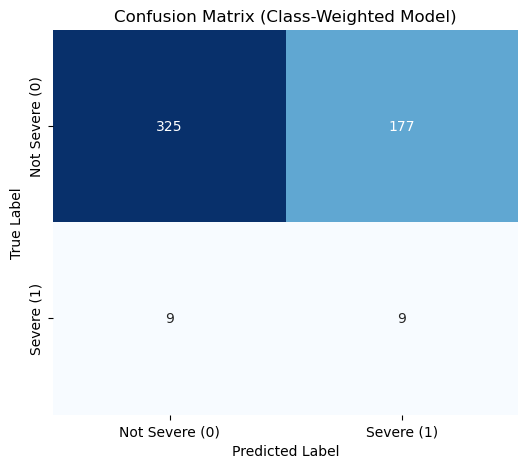

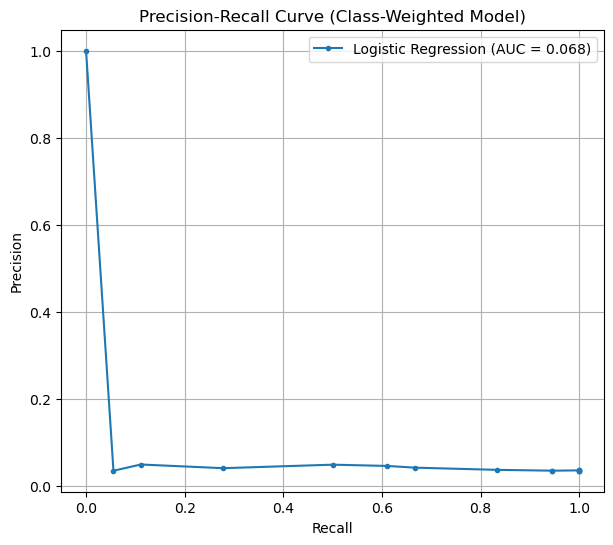

In [34]:
# Check target distribution
y = df['IS_SEVERE']
print("\n--- Target Variable Distribution (IS_SEVERE) ---")
print(y.value_counts(normalize=True).round(3))

# ## 3. Feature Cleaning and Preparation

# ### A. VAX_MANU Cleaning
df['VAX_MANU_CLEANED'] = df['VAX_MANU'].str.upper().replace({
    'PFIZER\\BIONTECH': 'PFIZER',
    'JANSSEN': 'JANSSEN',
    'MODERNA': 'MODERNA',
    'UNKNOWN MANUFACTURER': 'OTHER/UNKNOWN',
    'MODERNA - BIVALENT': 'MODERNA',
    'PFIZER\\BIONTECH - BIVALENT': 'PFIZER',
    'NOVAVAX': 'OTHER/UNKNOWN',
    'EMERGENT BIOSOLUTIONS': 'OTHER/UNKNOWN',
    'UNKNOWN': 'OTHER/UNKNOWN'
})

# ### B. VAX_DOSE_SERIES Cleaning
def clean_dose_series(dose):
    if pd.isna(dose) or dose in ['UNK']:
        return 'UNK'
    elif dose in ['1']:
        return '1'
    elif dose in ['2']:
        return '2'
    else: # Group doses 3+ together
        return '3+'

df['VAX_DOSE_SERIES_CLEANED'] = df['VAX_DOSE_SERIES'].astype(str).apply(clean_dose_series)

# Select features
features = ['VAX_MANU_CLEANED', 'VAX_DOSE_SERIES_CLEANED']
X = df[features]

# One-Hot Encode categorical features
X_encoded = pd.get_dummies(X, columns=features, drop_first=True)

# ## 4. Model Training: Logistic Regression

# Split the data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Use Logistic Regression with class_weight='balanced' to account for the highly imbalanced dataset.
print("\n--- Training Model ---")
logreg_model_balanced = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
logreg_model_balanced.fit(X_train, y_train)
print("Model trained successfully.")

# Predict on the test set
y_pred = logreg_model_balanced.predict(X_test)
y_pred_proba = logreg_model_balanced.predict_proba(X_test)[:, 1]

# ## 5. Model Evaluation and Visualization

# ### A. Accuracy Metrics
print("\n--- Accuracy Metrics (Class-Weighted Model) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ### B. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Severe (0)', 'Severe (1)'],
            yticklabels=['Not Severe (0)', 'Severe (1)'])
plt.title('Confusion Matrix (Class-Weighted Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() # In a notebook environment, use plt.show()

# ### C. Precision-Recall Curve Plot
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, marker='.', label=f'Logistic Regression (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Class-Weighted Model)')
plt.legend()
plt.grid(True)
plt.show() # In a notebook environment, use plt.show()